<a href="https://colab.research.google.com/github/CristoJV/Correlation-based-rx-notebook/blob/main/occ_trainning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

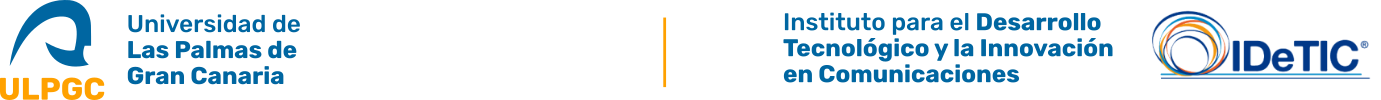

This notebook has been developed by Cristo Jurado-Verdu (cjurado@idetic.eu, develop@cristojv.com).

#Welcome 👍
This notebook contains very simplified routines comparable to the ones used in the papers published in the following journals and conferences:

- **Cristo Jurado-Verdu, Vicente Matus, Jose Rabadan, Victor Guerra, and Rafael Perez-Jimenez, "Correlation-based receiver for optical camera communications," Opt. Express 27, 19150-19155 (2019)**
[https://www.osapublishing.org/oe/fulltext.cfm?uri=oe-27-14-19150&id=414736](https://www.osapublishing.org/oe/fulltext.cfm?uri=oe-27-14-19150&id=414736)

- **C. Jurado-Verdu, V. Guerra, J. Rabadan, R. Perez-Jimenez and P. Chavez-Burbano, "RGB Synchronous VLC modulation scheme for OCC," 2018 11th International Symposium on Communication Systems, Networks & Digital Signal Processing (CSNDSP), 2018, pp. 1-6, doi: 10.1109/CSNDSP.2018.8471829.**
[https://ieeexplore.ieee.org/document/8471829](https://ieeexplore.ieee.org/document/8471829)
<br>

--------------------------------------------------------------------------------
>Please, if you have found these code snippets **helpful**, please **cite our work**. We will be delighted to receive **support** for releasing our source codes, and we will continue to provide all the material that may be useful for the community and learners. Thank you in advance.

--------------------------------------------------------------------------------
<br>

If you have any comments, contributions or queries, please feel free to contact me at cjurado@idetic.eu or develop@cristojv.com. I would be pleased to answer your questions and collaborate in future projects. You can reach me also at my LinkedIn [https://www.linkedin.com/in/cristojv/](https://www.linkedin.com/in/cristojv/) or personal website [https://cristojv.com](https://cristojv.com)

# 1.0 Introduction to Optical Camera Communications (OCC).
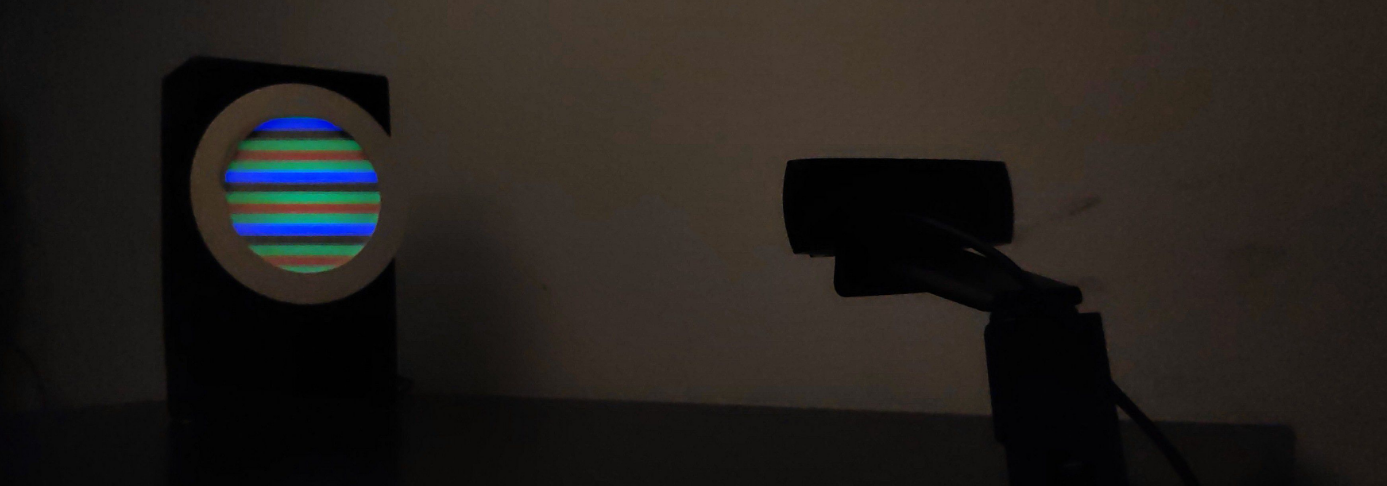

To better understand how optical camera communication (OCC) works, especially using rolling shutter (RS) cameras take a look at this [post](https://cristojv.com/explain-like-im-five-optical-camera-communications.html), where I try to explain in a very simple and illustrative way the basics of this technology and how RS cameras can work as data receivers.

In addition, in this [post](https://cristojv.com/insights-are-lamp-to-camera-links-occ-a-disruptive-communication-technology.html) I present my personal point of view about this technology, comparing it to traditional radio networks.

In the remainder of this notebook, you are going to work with real data captured from an enabled circular RGB lamp that was designed for this work. You will get in touch with every block contained in the following diagram.

<br>

-------------------------------------------------------------------------------
Image adquisition $\rightarrow$ Source detection $\rightarrow$ Training $\rightarrow$ Channel equalization $\rightarrow$ Binarization $\rightarrow$ Decoding

--------------------------------------------------------------------------------

<font size="4">Here you have a video description of the system **working** in our labs. It is explained in spanish, however the generated subtitles work well. 😀👍</font>

In [1]:
from IPython.display import HTML
HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/y-7HQIYmFoM"'\
     'title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; '\
     'clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')

## 1.1 Import necessary python modules
Firsly we will import the python modules that will provide the necessary image prosessing tools.
1. **NumPy**:
NumPy is the fundamental package for scientific computing with Python. It contains among other things: a powerful N-dimensional array object, sophisticated (broadcasting) functions, tools for integrating C/C++ and Fortran code, useful linear algebra, Fourier transform, and random number capabilities

1. **OpenCV**:
OpenCV (Open Source Computer Vision Library) is an open source computer vision and machine learning software library.
The library has more than 2500 optimized algorithms, which includes a comprehensive set of both classic and state-of-the-art computer vision and machine learning algorithms. These algorithms can be used to detect and recognize faces, identify objects, classify human actions in videos, track camera movements, track moving objects, extract 3D models of objects, produce 3D point clouds from stereo cameras, stitch images together to produce a high resolution image of an entire scene, find similar images from an image database, remove red eyes from images taken using flash, follow eye movements, recognize scenery and establish markers to overlay it with augmented reality, etc.

1. **Matplotlib**:
Matplotlib is a Python 2D plotting library which produces publication quality figures in a variety of hardcopy formats and interactive environments across platforms.

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 9]

print("Everything has been imported!")

Everything has been imported!


## 1.2 Clone repository containing the video file.

This video file contains an example of a real captured signal using a RS camera.

The frames in this video corresponds either to the beacon signal transmitted for source detection and training, and one example data packet.

In [3]:
!git clone https://gitlab.com/cristojv/correlation-based-rx-media

fatal: destination path 'correlation-based-rx-media' already exists and is not an empty directory.


# 2.0 Acquisition
The first step is to adquire frames from the camera (the video in this case) to process them. To do so we are going to use the VideoCapture object from the OpenCV module.

## 2.1 Use a VideoCapture device

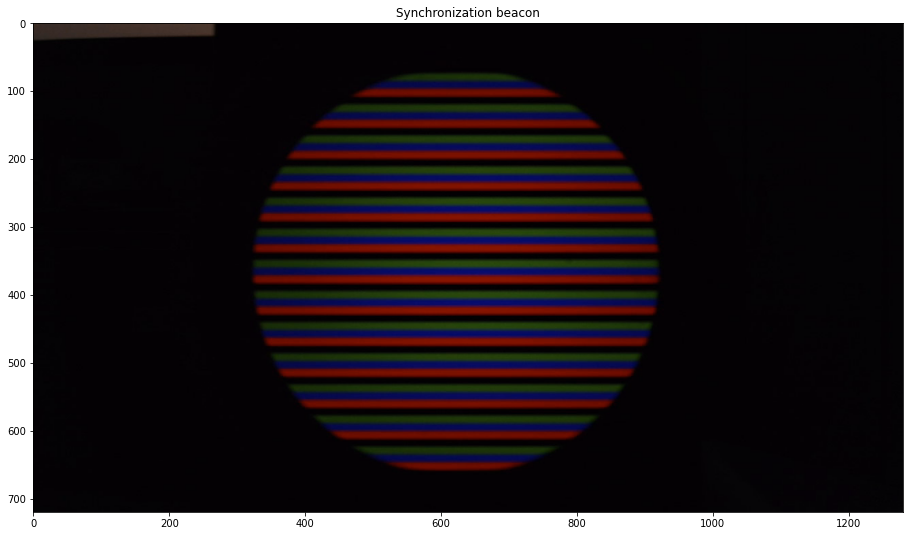

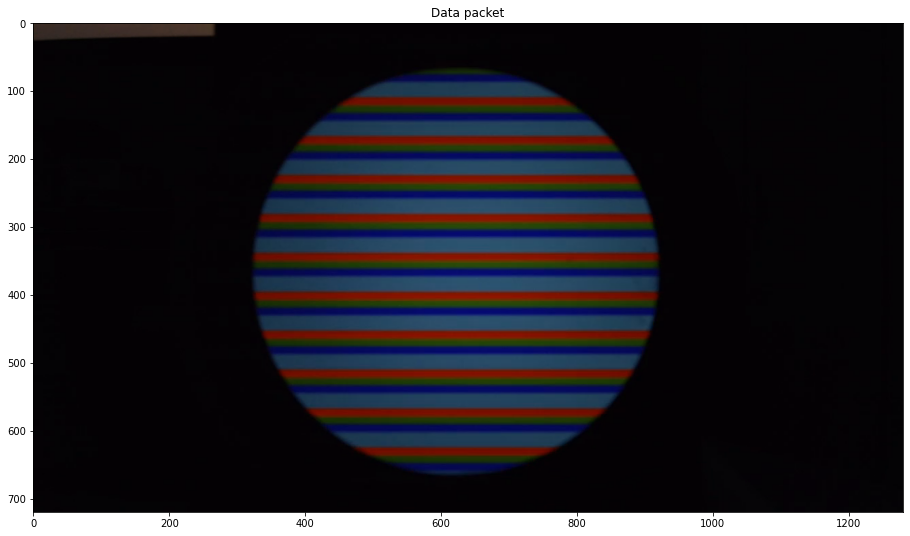

In [4]:
# Creating a VideoCapture object
video = cv2.VideoCapture('correlation-based-rx-media/video.mp4')
status, frame = video.read()
plt.imshow(frame)
plt.title('Synchronization beacon')
plt.show()

video.set(cv2.CAP_PROP_POS_FRAMES, 175)
status, data = video.read()
plt.imshow(data)
plt.title('Data packet')
plt.show()

This first two images are examples of the beacon signal (top) and the packet dataframe (bottom). Highlight that both the beacon and the packet is continuosly being sent (over the time of two frame captures) to ensure that at least one packet would fall within the region of interest (ROI).

# 3.0 Source detection
Then for the detection of the source, we are going to use the pearson correlation with the correspoding template to detect the beacons within the ROI.

## 3.1 Generate beacon and synchronization templates
The first step is to design the functions for generating those templates.

In [5]:
def generateROIDetectionTemplate(rowHeight, columnHeight, numberOfRows, numberOfRepetitions):
    template_g = np.repeat(np.array([[[0, 255, 0]]]), rowHeight, axis=0)
    template_r = np.repeat(np.array([[[0, 0, 255]]]), rowHeight, axis=0)
    template_b = np.repeat(np.array([[[255, 0, 0]]]), rowHeight, axis=0)
    template_n = np.repeat(np.array([[[0, 0, 0]]]), rowHeight, axis=0)
    templates = np.array([template_g,template_r,template_b,template_n
                              ])
    template_concat = templates[0]
    for i in range(1, numberOfRepetitions*numberOfRows):
        j = i % 4
        template_concat = np.concatenate((template_concat,templates[j]),axis=0)

    template = np.repeat(template_concat, columnHeight, axis=1)
    
    return template.astype(np.float32)/255.0

def generateSyncTemplate(rowHeight):
    template_g = np.repeat(255, rowHeight, axis=0)
    template_n = np.repeat(0, rowHeight, axis=0)
    template = np.concatenate((template_g,template_g,template_n,template_g,template_n),axis=0)
    return template.astype(np.float32)/255.0

Here you can visualize the output for each templates: the detection template, the calibration template, and the synchronization template.

(-0.5, 39.5, 131.5, -0.5)

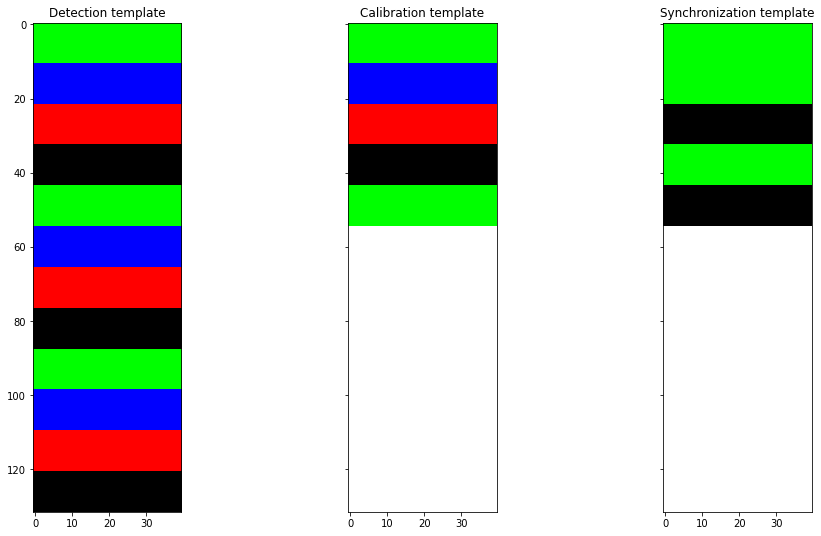

In [6]:
# Change the rowHeight and the columnHeight to adapt to the incomming data.
rowHeight = 11
columnHeight = 40
numberOfRepetitions = 3

detection_template = (generateROIDetectionTemplate(rowHeight = rowHeight, 
                                         columnHeight = columnHeight, 
                                         numberOfRows = 4, 
                                         numberOfRepetitions = numberOfRepetitions)*255).astype(np.uint8)
fig, ax = plt.subplots(1,3, sharey=True)
ax[0].imshow(detection_template)
ax[0].set_title("Detection template")

numberOfRepetitions = 1
calibration_template = (generateROIDetectionTemplate(rowHeight = rowHeight, 
                                         columnHeight = columnHeight, 
                                         numberOfRows = 5, 
                                         numberOfRepetitions = numberOfRepetitions)*255).astype(np.uint8)
ax[1].imshow(calibration_template)
ax[1].set_title("Calibration template")

synchronization_template = np.repeat(np.expand_dims((generateSyncTemplate(rowHeight = rowHeight)*255).astype(np.uint8),1),columnHeight,axis=1)
synchronization_template = np.repeat(np.expand_dims(synchronization_template, axis=2),3,axis=2)
synchronization_template[:,:,0] = 0
synchronization_template[:,:,2] = 0

ax[2].imshow(synchronization_template)
ax[2].set_title("Synchronization template")
ax[0].axis('scaled')
ax[1].axis('scaled')
ax[2].axis('scaled')

## 3.2 Match Template
The function that we are going to use for the ROI detection is:

## *cv2.matchTemplate* [Link to Documentation](https://docs.opencv.org/2.4/modules/imgproc/doc/object_detection.html?highlight=template%20match#cv2.matchTemplate)


Compares a template against overlapped image regions.
Python: cv2.matchTemplate(image, templ, method) → result

### Parameters
* *image* : Image where the search is running. It must be 8-bit or 32-bit floating-point.
* *templ* : Searched template. It must be not greater than the source image and have the same data type.
* *method*: Parameter specifying the comparison method

The function slides through *image* , compares the overlapped patches of size w \times h against *templ* using the specified method and stores the comparison results in *result* . Here are the formulae for the available comparison methods ( $I$ denotes *image*, $T$ *template*, $R$ *result*). The summation is done over template and/or the image patch:

$x' = 0...w-1, y'=0...h-1$
* method=CV_TM_SQDIFF
* method=CV_TM_SQDIFF_NORMED
* method=CV_TM_CCORR_NORMED
* method=CV_TM_CCOEFF
* method=CV_TM_CCOEFF_NORMED

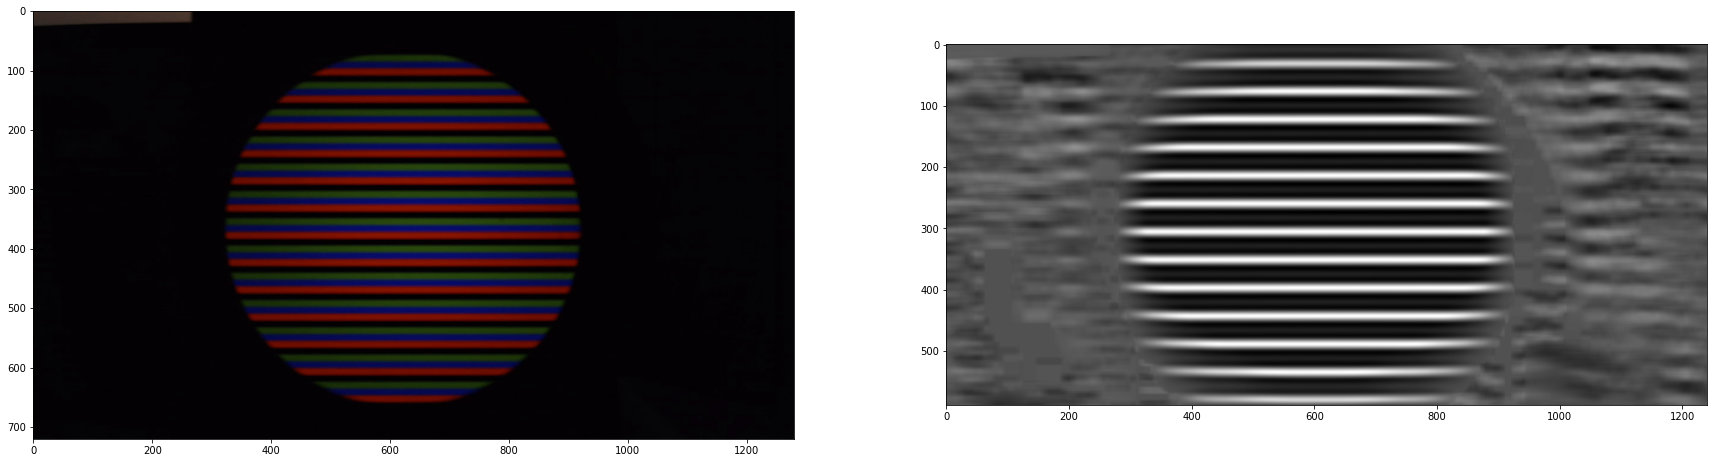

In [7]:
method = cv2.TM_CCOEFF_NORMED
result = cv2.matchTemplate(frame,detection_template,method)

# Only Green Channel
greenChannel = frame.copy()
greenChannel[:, :, 0] = 0
greenChannel[:, :, 2] = 0

greenChannelTemplate = detection_template.copy()
greenChannelTemplate[:, :, 0] = 0
greenChannelTemplate[:, :, 2] = 0

fig, matchTemplateAx = plt.subplots(1,2, figsize=(30,15))
matchTemplateAx[0].imshow(frame)
matchTemplateAx[1].imshow(result,cmap = 'gray')

In the last graphs, you can see the result of the correlation between the template and the image.
From this correlation the maximum value is localized in the image and it will set the ROI for detecting
the incoming packets.

## 3.3 Finding Maximum value

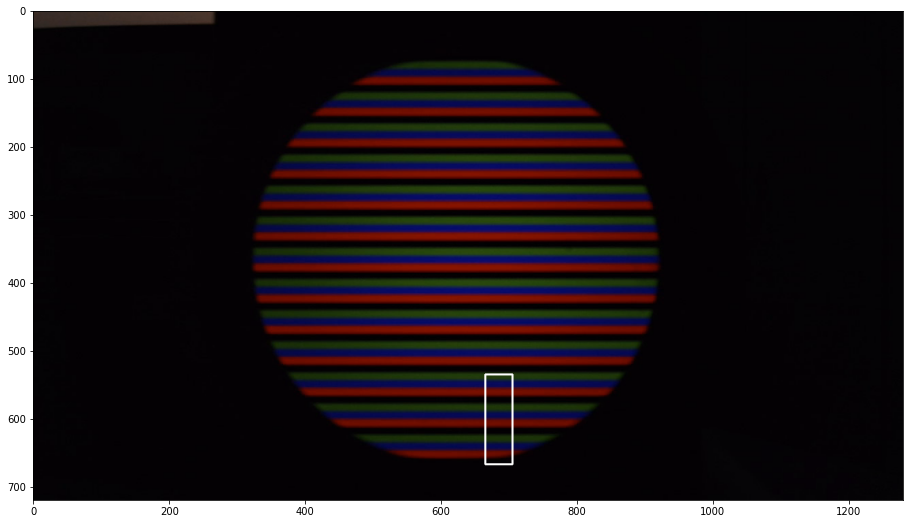

In [8]:
min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)
top_left = max_loc
h, w, z = detection_template.shape
bottom_right = (top_left[0] + w, top_left[1] + h)
roi= np.array((top_left, bottom_right))

roiFoundFrame = frame.copy()
cv2.rectangle(roiFoundFrame, tuple(roi[0]), tuple(roi[1]), (255,255,255), 2)
plt.imshow(roiFoundFrame)
plt.show()

In this example the ROI was detected at the end of the source's projection. However It can be discovered in any other place.

From now on, this is the ROI where all the following beacons and packets are expected to be detected. If in any frame the receiver does not detect any beacon or packet, then it will automatically run the correlation again in the entire image just to find another ROI.

## 3.4 ROI Mask
The following code shows the ROI detected.

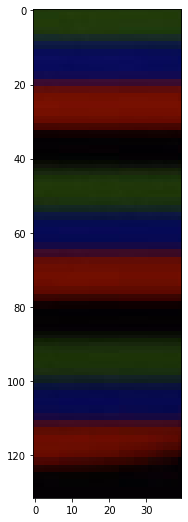

In [9]:
roiFrame = frame[roi[0][1]:roi[1][1],roi[0][0]:roi[1][0],:].copy()
plt.imshow(roiFrame)

# 4.0 Training

The purpose of the training step is to evaluate the interferences between the red, green and blue channels. As you can see in the following picture, when transmitting red symbols part of the energy reaches the green and blue channel due to the bayer filter design.
For example if we analyze each color channel independently, for exmaple the red channel, the interference from the green and blue channel is clearly noticeable. This interference must be mitigated.

To do so, we are going to use the beacon detected that is composed of a chain of band of the different colors: red, green, blue, black (no colors). Therefore, this beacon would allow the receiver to measure the channel interferences and proceed with the optimal equalization.

## 4.1 Channel interference

Here, you can visualize the interferences for each channel.

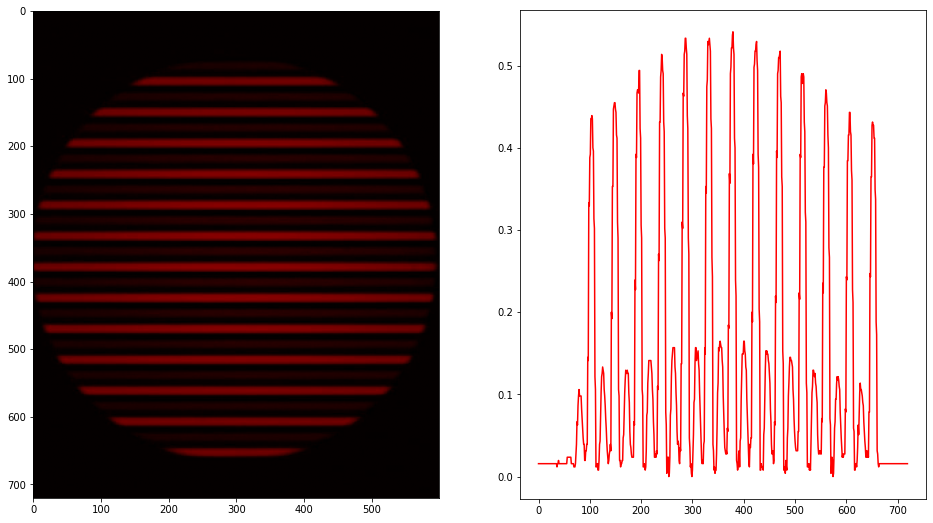

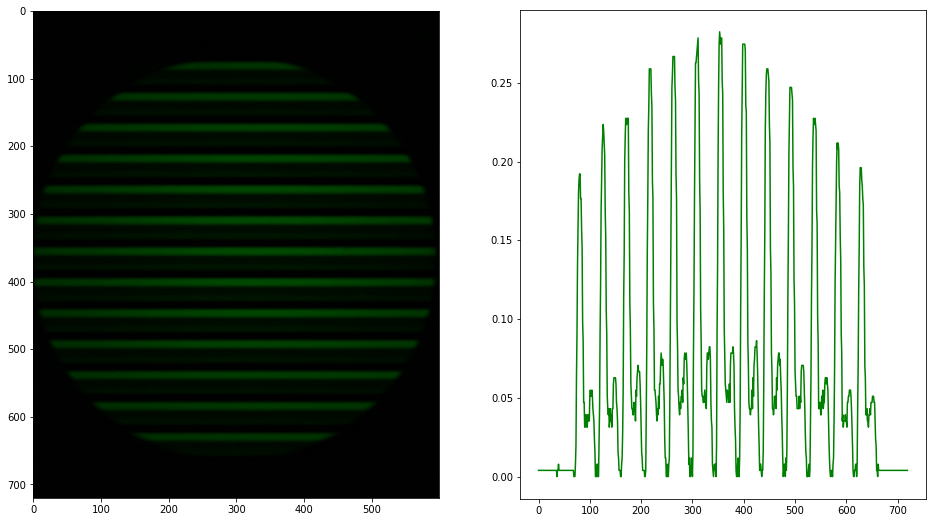

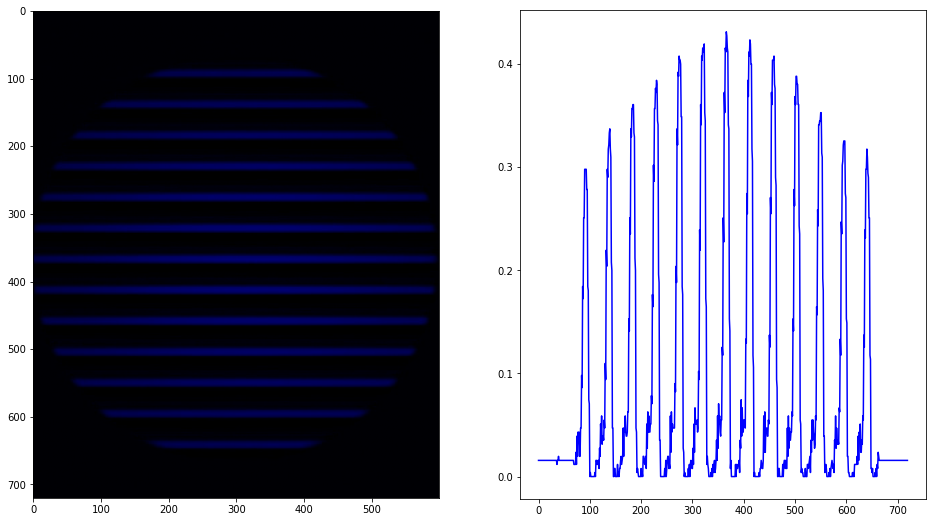

In [10]:
powerDistribution = frame.copy()/255.0
height,width,channels = powerDistribution.shape

line = powerDistribution[:,600:601,:]
powerDistribution = powerDistribution[:,325:925,:]
greenChannel = np.zeros((height,powerDistribution.shape[1],3))
greenChannel[:,:,1] = powerDistribution[:,:,1]
redChannel = np.zeros((height,powerDistribution.shape[1],3))
redChannel[:,:,0] = powerDistribution[:,:,0]
blueChannel = np.zeros((height,powerDistribution.shape[1],3))
blueChannel[:,:,2] = powerDistribution[:,:,2]

fig, redAx = plt.subplots(1,2)
redAx[0].imshow(redChannel)
redAx[1].plot(range(height),line[:,:,0],c='r')
fig, greenAx = plt.subplots(1,2)
greenAx[0].imshow(greenChannel)
greenAx[1].plot(range(height),line[:,:,1],c='g')
fig, blueAx = plt.subplots(1,2)
blueAx[0].imshow(blueChannel)
blueAx[1].plot(range(height),line[:,:,2],c='b')

plt.show()

## 4.2 Obtaining Channel Interference matrix.
In this step I recomend you to download the video from the local files, and play it in your computer. In this video you will see that the beacon *virtually* travels from top to bottom in subsequent frames. This is an important effect, due to the discretization of the sampling (vertical resolution of the camera), and can be exploited for training with less frames the channel equalizer over time.

This is an important contribution of this work. Generally, the training of the channel interferences is performed by illuminating the source with all the colors. However to do so it is necessary to hold each color for at least to frame captures. This is very disruptive and produce noticeable flickering. In this work, we rely in this well known beacon signal, that travels faster or slower depending on the packet design, to evaluate the interferences along the ROI. Hence the beacon can be used for both source detection and training.

How this travelling beacon is used for training is show in the following code.

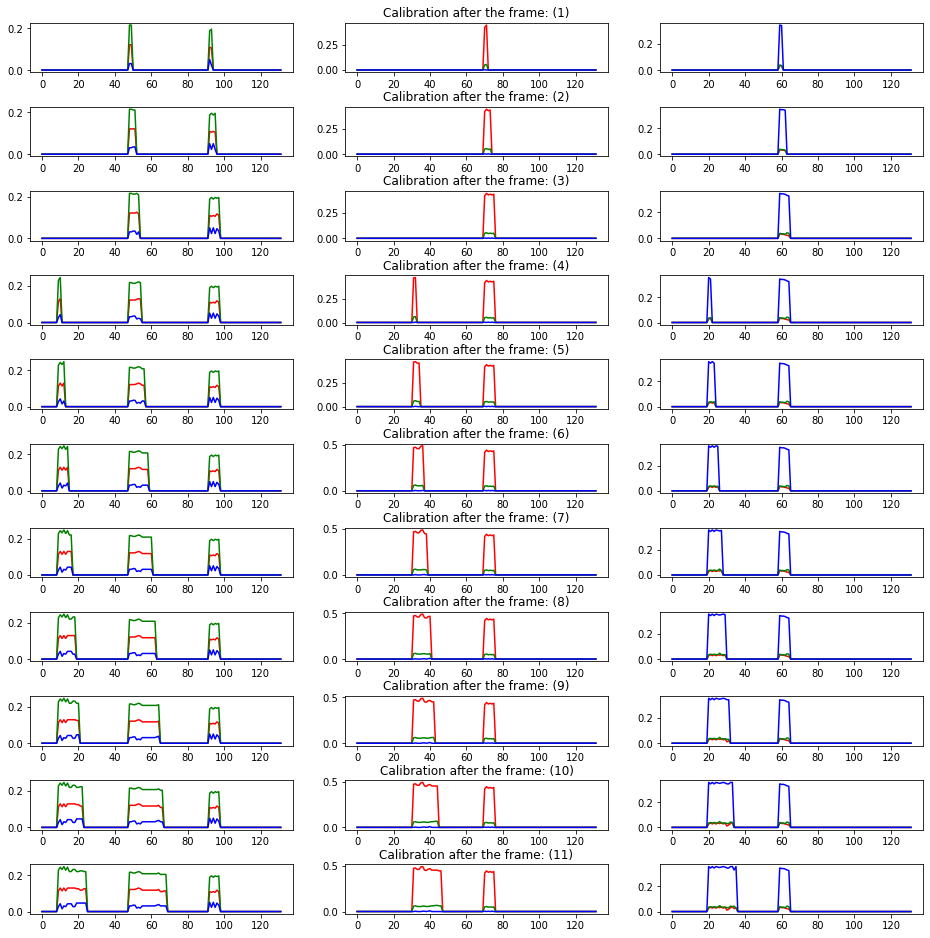

In [11]:
# Number of frames for calibration
calibrationMaxIterations = 10

video = cv2.VideoCapture('correlation-based-rx-media/video.mp4')
roiHeight = roi[1][1]-roi[0][1]

# ROI calibration measurements database for every channel.
redCalibrationMeasurements = np.zeros ((roiHeight,3))
greenCalibrationMeasurements = np.zeros ((roiHeight,3))
blueCalibrationMeasurements = np.zeros ((roiHeight,3))
redCalibrationMeasurements += 0.0005
greenCalibrationMeasurements += 0.0005
blueCalibrationMeasurements += 0.0005

# Template used for packet detection.
calibration_template = generateROIDetectionTemplate(rowHeight = 11, 
                                              columnHeight = 20,
                                              numberOfRows = 5, 
                                              numberOfRepetitions = 1)

fig, calAx = plt.subplots(calibrationMaxIterations+1,3)

for calibrationIteration in range(0,calibrationMaxIterations+1):
    status, frame = video.read()
    frame = frame.astype(np.float32)/255.0
    # Mask ROI
    roiFrame = frame[roi[0][1]:roi[1][1],roi[0][0]:roi[1][0],:].copy()
    # Look for packet template
    result = cv2.matchTemplate(roiFrame,calibration_template,method)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)
    topRow = max_loc[1]
    topColumn = max_loc[0]
    h, columnHeight, z = calibration_template.shape
    
    startingRow = rowHeight//2-rowHeight//2//3 + topRow
    endingRow = rowHeight//2+rowHeight//2//3 + topRow
    startingColumn = columnHeight//2 - 1
    endingColumn = columnHeight//2
    rows = endingRow - startingRow
    
    greenCalibrationMeasurements[startingRow:endingRow]=\
            (roiFrame[startingRow:endingRow,
             startingColumn:endingColumn]).reshape(rows,3)

    blueCalibrationMeasurements[startingRow+rowHeight:endingRow+rowHeight]\
            =(roiFrame[startingRow+rowHeight:endingRow+rowHeight,
              startingColumn:endingColumn]).reshape(rows,3)

    redCalibrationMeasurements[startingRow+2*rowHeight:endingRow+2*rowHeight]\
            =(roiFrame[startingRow+2*rowHeight:endingRow+2*rowHeight,
              startingColumn:endingColumn]).reshape(rows,3)
    
    greenCalibrationMeasurements[startingRow+4*rowHeight:endingRow+4*rowHeight]\
            =(roiFrame[startingRow+4*rowHeight:endingRow+4*rowHeight,
              startingColumn:endingColumn]).reshape(rows,3)
    
    calAx[calibrationIteration,1].title.set_text(
        'Calibration after the frame: ({})'.format(calibrationIteration+1))
    
    calAx[calibrationIteration,0].plot(greenCalibrationMeasurements[:,0],c='r')
    calAx[calibrationIteration,0].plot(greenCalibrationMeasurements[:,1],c='g')
    calAx[calibrationIteration,0].plot(greenCalibrationMeasurements[:,2],c='b')
    calAx[calibrationIteration,1].plot(redCalibrationMeasurements[:,0],c='r')
    calAx[calibrationIteration,1].plot(redCalibrationMeasurements[:,1],c='g')
    calAx[calibrationIteration,1].plot(redCalibrationMeasurements[:,2],c='b')
    calAx[calibrationIteration,2].plot(blueCalibrationMeasurements[:,0],c='r')
    calAx[calibrationIteration,2].plot(blueCalibrationMeasurements[:,1],c='g')
    calAx[calibrationIteration,2].plot(blueCalibrationMeasurements[:,2],c='b')

plt.subplots_adjust(top=1.5,hspace=0.7)
plt.show()

This graphs shows how the training evolves after capturing 10 frames. As you can see on the transmitted beacon green bands (graphs of the left) there is channel interference from red and blue channels. The same happens with the transmitted beacon red bands (middle graphs), and the blue bands (right graphs).

As you can see, thanks to the beacon is travelling, the receiver detects more points within the ROI, and will accumulate the channel values until it has the necesary points to perform the optimal channel equalization. From experiments, this number is usually 5 consecutive frames.

Highlight that for learning purposes the traveling speed is very low between frames. The ideal case would be a faster speed increasing the probability of detecting a new beacon in different places, making more uniform the detected channel values along the ROI.

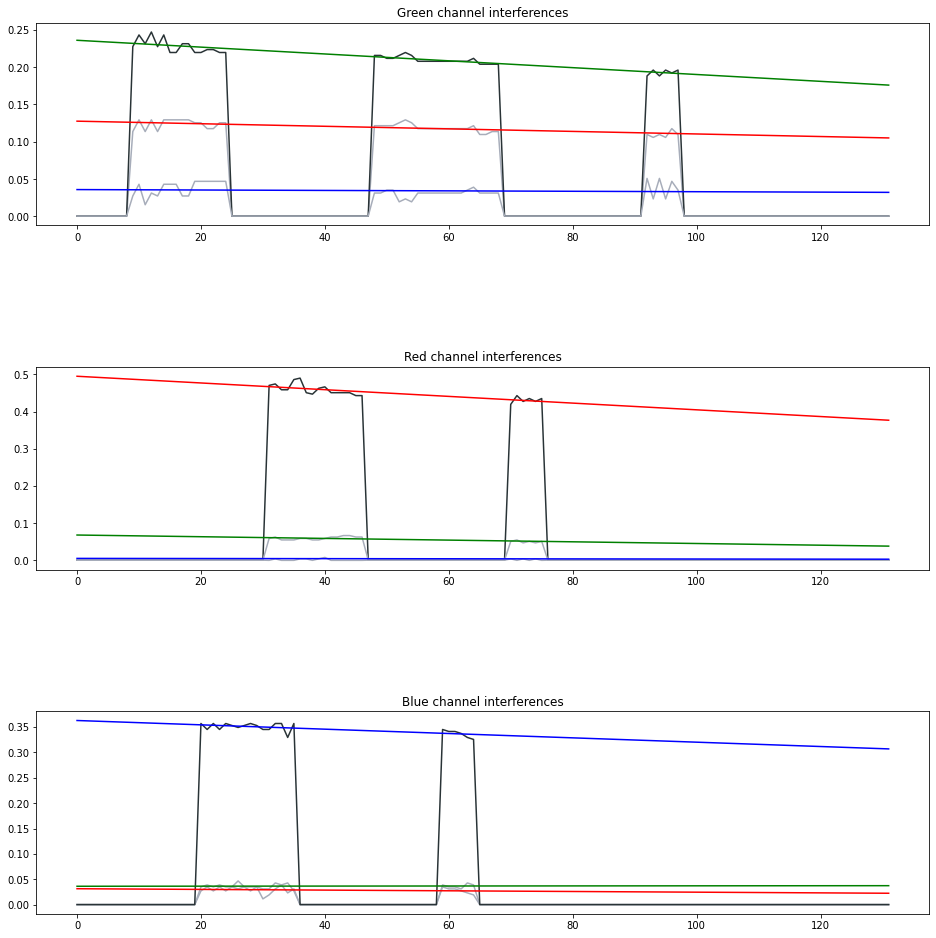

In [12]:
def polinomialFitting(calibrationMeasurements, ord=1):
    
    x = np.arange(len(calibrationMeasurements))
    idx0 = np.greater(calibrationMeasurements[:,0],0.0005)
    idx1 = np.greater(calibrationMeasurements[:,1],0.0005)
    idx2 = np.greater(calibrationMeasurements[:,2],0.0005)

    greenFitting = np.polyfit(x[idx1], calibrationMeasurements[idx1,1], ord)
    blueFitting = np.polyfit(x[idx2], calibrationMeasurements[idx2,2], ord)
    redFitting = np.polyfit(x[idx0], calibrationMeasurements[idx0,0], ord)

    greenFitter = np.poly1d(greenFitting)
    blueFitter = np.poly1d(blueFitting)
    redFitter = np.poly1d(redFitting)

    greenAjustment = greenFitter(x)
    blueAjustment = blueFitter(x)
    redAjustment = redFitter(x)
    
    return np.concatenate((redAjustment.reshape(calibrationMeasurements.shape[0],1),\
                           greenAjustment.reshape(calibrationMeasurements.shape[0],1),\
                           blueAjustment.reshape(calibrationMeasurements.shape[0],1)),axis=1)

greenAjustments = polinomialFitting(greenCalibrationMeasurements)
blueAjustments = polinomialFitting(blueCalibrationMeasurements)
redAjustments = polinomialFitting(redCalibrationMeasurements)

fig, ajustAx = plt.subplots(3,1)

ajustAx[1].title.set_text('Red channel interferences')
ajustAx[1].plot(redCalibrationMeasurements[:,0],c='#293336')
ajustAx[1].plot(redCalibrationMeasurements[:,1],c='#a7adba')
ajustAx[1].plot(redCalibrationMeasurements[:,2],c='#a7adba')

ajustAx[1].plot(redAjustments[:,0],c='r')
ajustAx[1].plot(redAjustments[:,1],c='g')
ajustAx[1].plot(redAjustments[:,2],c='b')

ajustAx[0].title.set_text('Green channel interferences')
ajustAx[0].plot(greenCalibrationMeasurements[:,0],c='#a7adba')
ajustAx[0].plot(greenCalibrationMeasurements[:,1],c='#293336')
ajustAx[0].plot(greenCalibrationMeasurements[:,2],c='#a7adba')

ajustAx[0].plot(greenAjustments[:,0],c='r')
ajustAx[0].plot(greenAjustments[:,1],c='g')
ajustAx[0].plot(greenAjustments[:,2],c='b')

ajustAx[2].title.set_text('Blue channel interferences')
ajustAx[2].plot(blueCalibrationMeasurements[:,0],c='#a7adba')
ajustAx[2].plot(blueCalibrationMeasurements[:,1],c='#a7adba')
ajustAx[2].plot(blueCalibrationMeasurements[:,2],c='#293336')

ajustAx[2].plot(blueAjustments[:,0],c='r')
ajustAx[2].plot(blueAjustments[:,1],c='g')
ajustAx[2].plot(blueAjustments[:,2],c='b')

plt.subplots_adjust(top=1.5,hspace=0.7)
plt.show()

After accumulating different sampling points (channel values) within the ROI, a polynomial fitting is performed for all the interferences computing the channel inteference matrix.

## 4.3 Channel interference matrix and threshold

[[1.         0.10146893 0.00814913]
 [0.59783432 1.         0.18351134]
 [0.07437023 0.12292607 1.        ]]


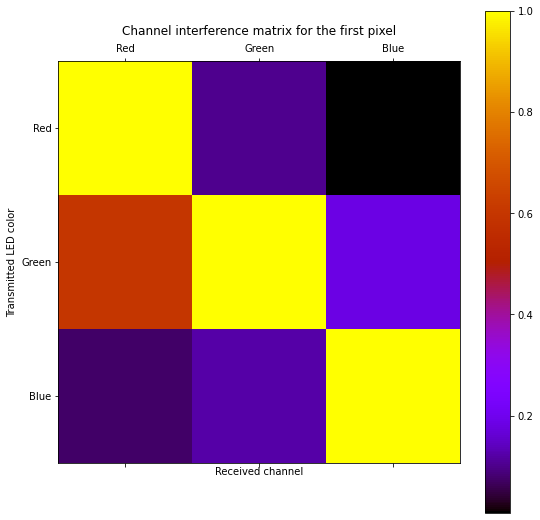

In [13]:
invColorMatrix = 0
spatialThresholding = 0
numberOfSamples = len(greenCalibrationMeasurements)

redNormalization = np.divide(redAjustments,redAjustments[:,0].reshape(numberOfSamples,1))
greenNormalization = np.divide(greenAjustments,greenAjustments[:,1].reshape(numberOfSamples,1))
blueNormalization = np.divide(blueAjustments,blueAjustments[:,2].reshape(numberOfSamples,1))

for i in range(0,numberOfSamples):
    currentMatrix = np.concatenate(
        (redNormalization[i, :].reshape(1,3),
        greenNormalization[i,:].reshape(1,3),
        blueNormalization[i,:].reshape(1,3)),axis=0).reshape(1,3,3)
    try:
        inverse = np.linalg.inv(currentMatrix)
    except np.linalg.LinAlgError:
        print("Inverse matrix not computable")
        pass
    else:
        if(i==0):
            invColorMatrix = inverse
        else:
            invColorMatrix = np.concatenate((invColorMatrix, inverse))

spatialThresholding = np.concatenate((redAjustments[:,0].reshape(numberOfSamples,1),
                                      greenAjustments[:,1].reshape(numberOfSamples,1),
                                      blueAjustments[:,2].reshape(numberOfSamples,1)),axis=1)
plt.matshow(currentMatrix[0], cmap='gnuplot')
plt.ylabel("Transmitted LED color")
plt.xlabel("Received channel")
plt.yticks(ticks=np.arange(3),labels=["Red","Green","Blue"])
plt.xticks(ticks=np.arange(3),labels=["Red","Green","Blue"])
plt.colorbar()
plt.title("Channel interference matrix for the first pixel")
print(currentMatrix[0])

# 5.0 Channel equalization
Finally, the channel equalization is applied to the received signal.



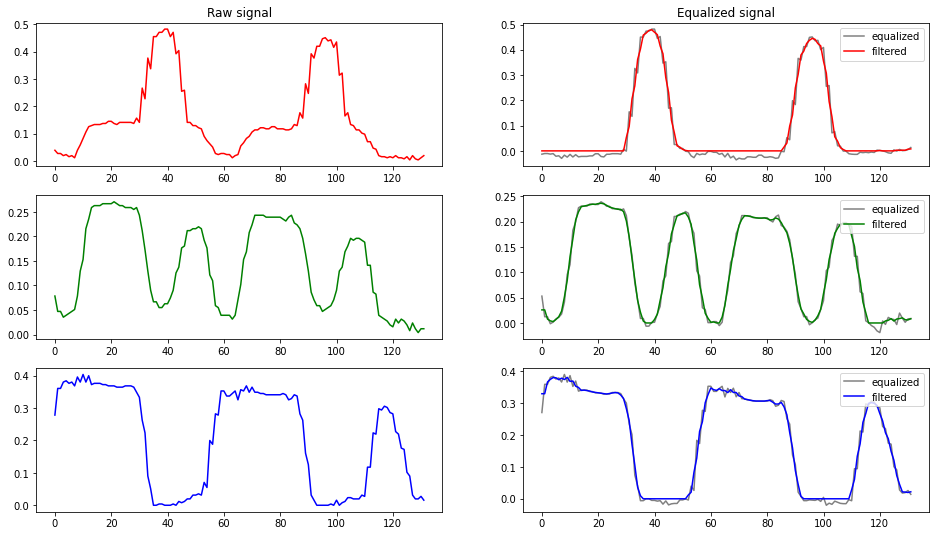

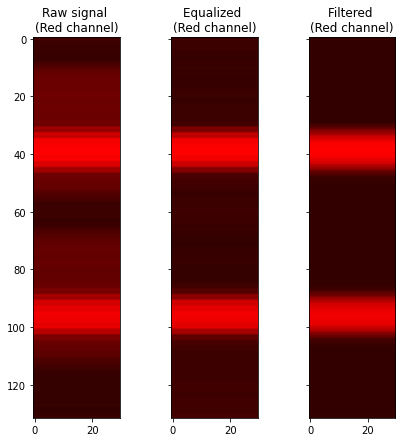

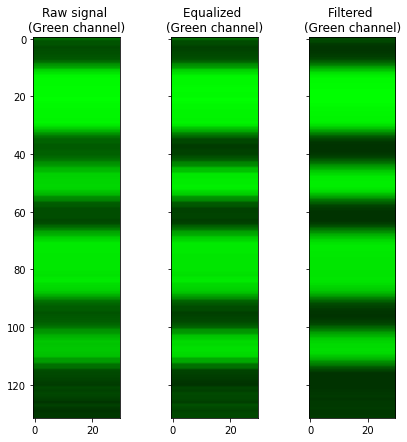

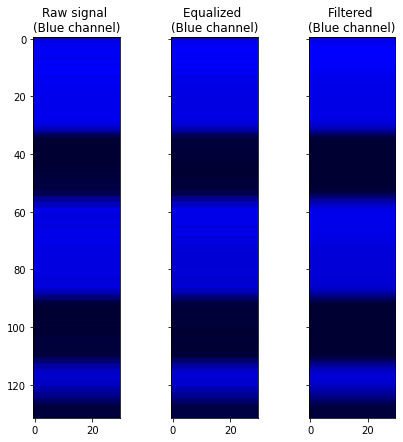

In [14]:
from matplotlib.colors import LinearSegmentedColormap
video.set(cv2.CAP_PROP_POS_FRAMES, 175)
status, frame = video.read()

# Previous ROI detected
roiHeight = roi[1][1]-roi[0][1]
frame = frame.astype(np.float32)/255.0

# Mask ROI
roiFrame = frame[roi[0][1]:roi[1][1],roi[0][0]:roi[1][0],:].copy()
numberOfSamples,width,channels = roiFrame.shape
roiFrame = roiFrame[:,width//2,:]
colorAdaptedSignal = 0

for i in range (0,numberOfSamples):
    colorAdaptedSample = np.dot(roiFrame[i],invColorMatrix[i]).reshape(1, 3)
    if i == 0:
        colorAdaptedSignal = colorAdaptedSample
    else:
        colorAdaptedSignal = np.concatenate((colorAdaptedSignal,colorAdaptedSample))

colorAdaptedSignalFiltered = cv2.blur(colorAdaptedSignal,(1,3))
colorAdaptedSignalFiltered[colorAdaptedSignalFiltered<=0] = 0

# Plots
fig, colorAdaptedAx = plt.subplots(3,2)
colorAdaptedAx[0,0].title.set_text('Raw signal')
colorAdaptedAx[0,0].plot(roiFrame[:,0], c='r')
colorAdaptedAx[0,1].title.set_text('Equalized signal')
colorAdaptedAx[0,1].plot(colorAdaptedSignal[:,0], c='gray',label="equalized")
colorAdaptedAx[0,1].plot(colorAdaptedSignalFiltered[:,0], c='r',label="filtered")
colorAdaptedAx[0,1].legend(loc='upper right')
colorAdaptedAx[1,0].plot(roiFrame[:,1], c='g')
colorAdaptedAx[1,1].plot(colorAdaptedSignal[:,1], c='gray',label="equalized")
colorAdaptedAx[1,1].plot(colorAdaptedSignalFiltered[:,1], c='g',label="filtered")
colorAdaptedAx[1,1].legend(loc='upper right')
colorAdaptedAx[2,0].plot(roiFrame[:,2], c='b')
colorAdaptedAx[2,1].plot(colorAdaptedSignal[:,2], c='gray',label="equalized")
colorAdaptedAx[2,1].plot(colorAdaptedSignalFiltered[:,2], c='b',label="filtered")
colorAdaptedAx[2,1].legend(loc='upper right')

roiFrame = np.repeat(roiFrame, 30, axis=1)
colorAdaptedSignalPlot = colorAdaptedSignal.copy()
colorAdaptedSignalPlot = np.repeat(colorAdaptedSignalPlot, 30, axis=1)

colorAdaptedSignalFilteredPlot = colorAdaptedSignalFiltered.copy()
colorAdaptedSignalFilteredPlot = np.repeat(colorAdaptedSignalFilteredPlot, 30, axis=1)

fig, colorAdaptedPlotAx = plt.subplots(1,3,figsize=(7,7),sharey=True)
cm = LinearSegmentedColormap.from_list("Custom", [(0.2, 0, 0), (1, 0, 0)], N=100)
colorAdaptedPlotAx[0].title.set_text('Raw signal \n(Red channel)')
colorAdaptedPlotAx[0].imshow(roiFrame[:,:30],cmap=cm)
colorAdaptedPlotAx[1].title.set_text('Equalized \n(Red channel)')
colorAdaptedPlotAx[1].imshow(colorAdaptedSignalPlot[:,:30],cmap=cm)
colorAdaptedPlotAx[2].title.set_text('Filtered \n(Red channel)')
colorAdaptedPlotAx[2].imshow(colorAdaptedSignalFilteredPlot[:,:30],cmap=cm)

fig, colorAdaptedPlotAx = plt.subplots(1,3,figsize=(7,7),sharey=True)
cm = LinearSegmentedColormap.from_list("Custom", [(0, 0.2, 0), (0, 1, 0)], N=100)
colorAdaptedPlotAx[0].title.set_text('Raw signal \n(Green channel)')
colorAdaptedPlotAx[0].imshow(roiFrame[:,30:60],cmap=cm)
colorAdaptedPlotAx[1].title.set_text('Equalized \n(Green channel)')
colorAdaptedPlotAx[1].imshow(colorAdaptedSignalPlot[:,30:60],cmap=cm)
colorAdaptedPlotAx[2].title.set_text('Filtered \n(Green channel)')
colorAdaptedPlotAx[2].imshow(colorAdaptedSignalFilteredPlot[:,30:60],cmap=cm)

fig, colorAdaptedPlotAx = plt.subplots(1,3,figsize=(7,7),sharey=True)
cm = LinearSegmentedColormap.from_list("Custom", [(0, 0, 0.2), (0, 0, 1)], N=100)
colorAdaptedPlotAx[0].title.set_text('Raw signal \n(Blue channel)')
colorAdaptedPlotAx[0].imshow(roiFrame[:,60:90],cmap=cm)
colorAdaptedPlotAx[1].title.set_text('Equalized \n(Blue channel)')
colorAdaptedPlotAx[1].imshow(colorAdaptedSignalPlot[:,60:90],cmap=cm)
colorAdaptedPlotAx[2].title.set_text('Filtered \n(Blue channel)')
colorAdaptedPlotAx[2].imshow(colorAdaptedSignalFilteredPlot[:,60:90],cmap=cm)

plt.show()

In the previous images you can se the channel equalization. On the left figures you see the original captured signal with channel interferences. On the righ figures you see the channel-equalized signal.
On the bottom figures you will see the process for each channel (red, green and blue) from original (left), equalized (middle) and filtered (right).

# 6.0 Binarization
The last step is to apply the corresponding thresholding (computed in the training stage) and then demodulate the data.

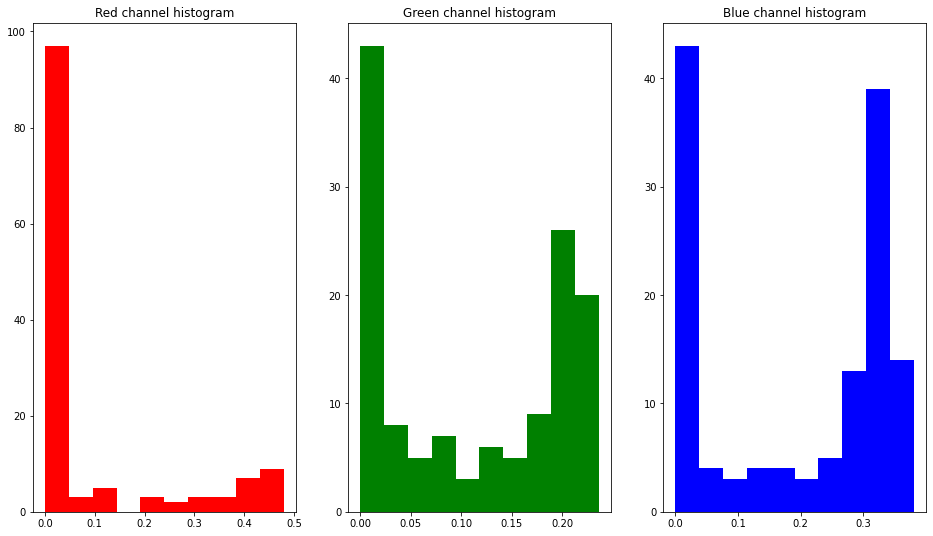

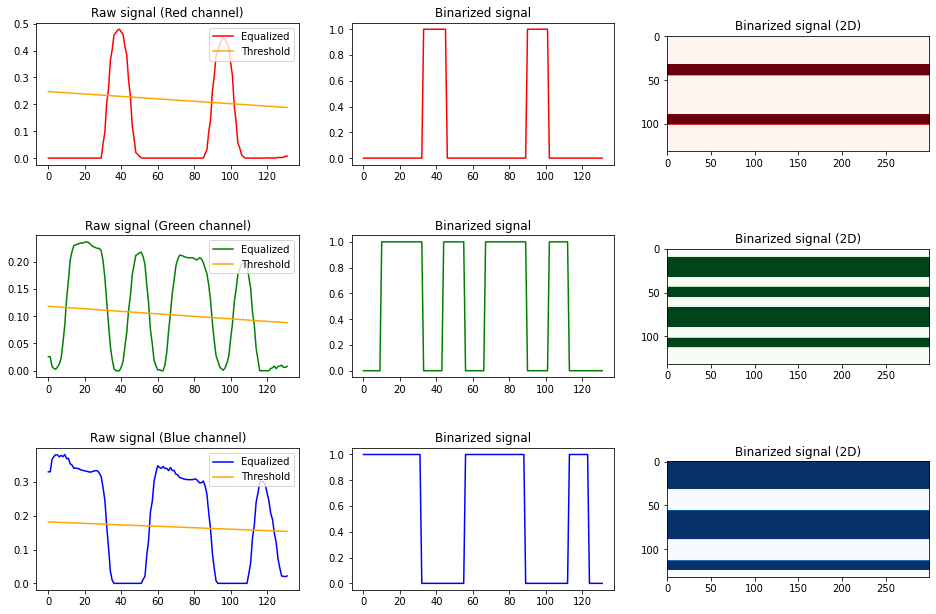

In [15]:
binarizeSignal = 0
signal = colorAdaptedSignalFiltered.copy()
numberOfSamples = len(signal)

redChannel = np.zeros(numberOfSamples).reshape(numberOfSamples,1)
greenChannel = np.zeros(numberOfSamples).reshape(numberOfSamples,1)
blueChannel = np.zeros(numberOfSamples).reshape(numberOfSamples,1)

fig, histAx = plt.subplots(1,3)
histAx[0].title.set_text('Red channel histogram')
histAx[0].hist(signal[:,0], bins=10, color='r')
histAx[1].title.set_text('Green channel histogram')
histAx[1].hist(signal[:,1], bins=10, color='g')
histAx[2].title.set_text('Blue channel histogram')
histAx[2].hist(signal[:,2], bins=10, color='b')

redChannel[np.less(spatialThresholding[:,0]/2,signal[:,0], where=True)] = 1.0
greenChannel[np.less(spatialThresholding[:,1]/2,signal[:,1], where=True)] = 1.0
blueChannel[np.less(spatialThresholding[:,2]/2,signal[:,2], where=True)] = 1.0

binarizeSignal = np.concatenate((redChannel,greenChannel,blueChannel),axis=1)

binarizedSignalPlot = binarizeSignal.copy()
binarizedSignalPlot = np.expand_dims(binarizedSignalPlot, axis=1)
binarizedSignalPlot = np.repeat(binarizedSignalPlot, 300, axis=1)

fig, colorAdaptedPlotAx = plt.subplots(3,3)
colorAdaptedPlotAx[0,0].title.set_text('Raw signal (Red channel)')
colorAdaptedPlotAx[0,0].plot(colorAdaptedSignalFiltered[:,0],c='r',label='Equalized')
colorAdaptedPlotAx[0,0].plot(spatialThresholding[:,0]/2,c='orange',label='Threshold')
colorAdaptedPlotAx[0,0].legend(loc='upper right')
colorAdaptedPlotAx[0,1].title.set_text('Binarized signal')
colorAdaptedPlotAx[0,1].plot(redChannel,c='r')
colorAdaptedPlotAx[0,2].title.set_text('Binarized signal (2D)')
colorAdaptedPlotAx[0,2].imshow(binarizedSignalPlot[:,:,0], cmap='Reds')
colorAdaptedPlotAx[1,0].title.set_text('Raw signal (Green channel)')
colorAdaptedPlotAx[1,0].plot(colorAdaptedSignalFiltered[:,1],c='g',label='Equalized')
colorAdaptedPlotAx[1,0].plot(spatialThresholding[:,1]/2,c='orange',label='Threshold')
colorAdaptedPlotAx[1,0].legend(loc='upper right')
colorAdaptedPlotAx[1,1].title.set_text('Binarized signal')
colorAdaptedPlotAx[1,1].plot(greenChannel,c='g')
colorAdaptedPlotAx[1,2].title.set_text('Binarized signal (2D)')
colorAdaptedPlotAx[1,2].imshow(binarizedSignalPlot[:,:,1], cmap='Greens')
colorAdaptedPlotAx[2,0].title.set_text('Raw signal (Blue channel)')
colorAdaptedPlotAx[2,0].plot(colorAdaptedSignalFiltered[:,2],c='b',label='Equalized')
colorAdaptedPlotAx[2,0].plot(spatialThresholding[:,2]/2,c='orange',label='Threshold')
colorAdaptedPlotAx[2,0].legend(loc='upper right')
colorAdaptedPlotAx[2,1].title.set_text('Binarized signal')
colorAdaptedPlotAx[2,1].plot(blueChannel,c='b')
colorAdaptedPlotAx[2,2].title.set_text('Binarized signal (2D)')
colorAdaptedPlotAx[2,2].imshow(binarizedSignalPlot[:,:,2], cmap='Blues')

plt.subplots_adjust(top=1,hspace=0.5)
plt.show()

# 7.0 Decoding
For the decoding, the green channel is correlated with the synchronization template to synchronize the symbol sampling points.

Then, the data is recovered from the red and the blue channels.

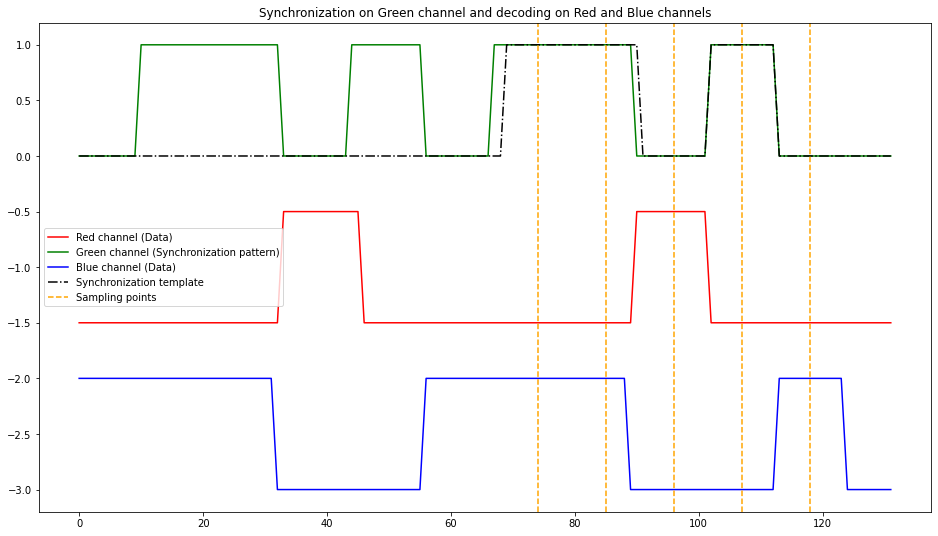

In [16]:
synchronization_template = generateSyncTemplate(rowHeight = 11)

synchronization_templateN = (synchronization_template - np.mean(synchronization_template)) / (np.std(synchronization_template) * len(synchronization_template))
greenChannelN = (greenChannel - np.mean(greenChannel)) /  np.std(greenChannel)
greenChannelN = np.reshape(greenChannelN,len(greenChannelN))
correlation = np.correlate(greenChannelN,synchronization_templateN)

maxValue = np.amax(correlation)
maxIndexValue = np.argmax(correlation)

correlationPlot = np.zeros(len(greenChannelN))
correlationPlot[maxIndexValue:maxIndexValue+len(synchronization_template)] = synchronization_template
plt.plot(redChannel-1.5,c='r',label="Red channel (Data)")
plt.plot(greenChannel,c='g',label="Green channel (Synchronization pattern)")
plt.plot(blueChannel-3,c='b',label="Blue channel (Data)")
plt.plot(correlationPlot,c='black',linestyle='-.',label="Synchronization template")

sampling_points = np.arange(rowHeight//2, len(synchronization_template), rowHeight)+maxIndexValue
for idx,sampling_point in enumerate(sampling_points):
  plt.axvline(sampling_point,color='orange',linestyle='--',label="Sampling points" if idx==0 else "")
plt.legend(loc='center left')
plt.title("Synchronization on Green channel and decoding on Red and Blue channels")
plt.show()